In [547]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from tqdm import tqdm
from datetime import timedelta


In [548]:
# Read and preprocess the data
data = pd.read_csv('data_processed_filtered_outlier_imputed.csv')
data['is_weekend'] = data['is_weekend'].apply(lambda x: 1 if x == 'True' else 0)


In [549]:

# Select features and target variable
selected_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend','engagement']
target = ['engagement']

X = data[selected_features].values
y = data[target].values



In [550]:
# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)


In [551]:
# Custom dataset class for time series data
class EngagementDataset(Dataset):
    def __init__(self, X, y, time_steps):
        self.X = X
        self.y = y
        self.time_steps = time_steps

    def __len__(self):
        return len(self.X) - self.time_steps

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.time_steps]
        y_seq = self.y[idx + self.time_steps]

        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [552]:
# Set time steps (sequence length)
time_steps = 20
dataset = EngagementDataset(X_scaled, y_scaled, time_steps)


In [553]:
# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

import torch.nn.functional as F

In [554]:
# Simple BERT-like transformer model for regression
class SimpleBERT(nn.Module):
    def __init__(self, vocab_size=30522, hidden_size=64, num_hidden_layers=4, num_attention_heads=4,
                 intermediate_size=256, dropout_rate=0.1):
        super(SimpleBERT, self).__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Embedding layer: Since there are no word embeddings, it's simplified to a linear layer
        self.embedding = nn.Linear(vocab_size, hidden_size)

        # Transformer layers
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_attention_heads,
                dim_feedforward=intermediate_size,
                dropout=dropout_rate
            ) for _ in range(num_hidden_layers)
        ])

        self.dropout = nn.Dropout(dropout_rate)

        # Regression head (fully connected layers for output)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, input_ids):
        # Input shape: (batch_size, sequence_length, feature_size)
        embedding_output = self.embedding(input_ids)
        hidden_states = embedding_output

        # Transformer encoder layers
        for layer in self.layers:
            hidden_states = layer(hidden_states)

        # Pooling: Taking the mean across sequence length
        pooled_output = hidden_states.mean(dim=1)

        # Pass through the fully connected layers
        x = F.relu(self.fc1(pooled_output))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output shape (batch_size, 1)

        return x


In [555]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer,device, num_epochs=5):
    best_val_loss = float('inf')
    
    # 保存每个 epoch 的损失
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)  # 保存训练损失

        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.squeeze())
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)  # 保存验证损失

        # Print loss for each epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_bert_model.pth')

    return train_losses, val_losses


In [556]:
# Set device, loss function, and optimizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleBERT(vocab_size=len(selected_features)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)



In [557]:
# Custom dataset class for time series data
class EngagementDataset(Dataset):
    def __init__(self, X, y, time_steps):
        self.X = X
        self.y = y
        self.time_steps = time_steps

    def __len__(self):
        return len(self.X) - self.time_steps

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.time_steps]
        y_seq = self.y[idx + self.time_steps]

        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


Epoch 1/200, Training Loss: 0.0394, Validation Loss: 0.0268
Epoch 2/200, Training Loss: 0.0268, Validation Loss: 0.0232
Epoch 3/200, Training Loss: 0.0245, Validation Loss: 0.0221
Epoch 4/200, Training Loss: 0.0234, Validation Loss: 0.0218
Epoch 5/200, Training Loss: 0.0230, Validation Loss: 0.0223
Epoch 6/200, Training Loss: 0.0225, Validation Loss: 0.0216
Epoch 7/200, Training Loss: 0.0225, Validation Loss: 0.0217
Epoch 8/200, Training Loss: 0.0226, Validation Loss: 0.0217
Epoch 9/200, Training Loss: 0.0227, Validation Loss: 0.0215
Epoch 10/200, Training Loss: 0.0224, Validation Loss: 0.0214
Epoch 11/200, Training Loss: 0.0220, Validation Loss: 0.0215
Epoch 12/200, Training Loss: 0.0223, Validation Loss: 0.0214
Epoch 13/200, Training Loss: 0.0223, Validation Loss: 0.0215
Epoch 14/200, Training Loss: 0.0223, Validation Loss: 0.0212
Epoch 15/200, Training Loss: 0.0221, Validation Loss: 0.0212
Epoch 16/200, Training Loss: 0.0222, Validation Loss: 0.0213
Epoch 17/200, Training Loss: 0.02

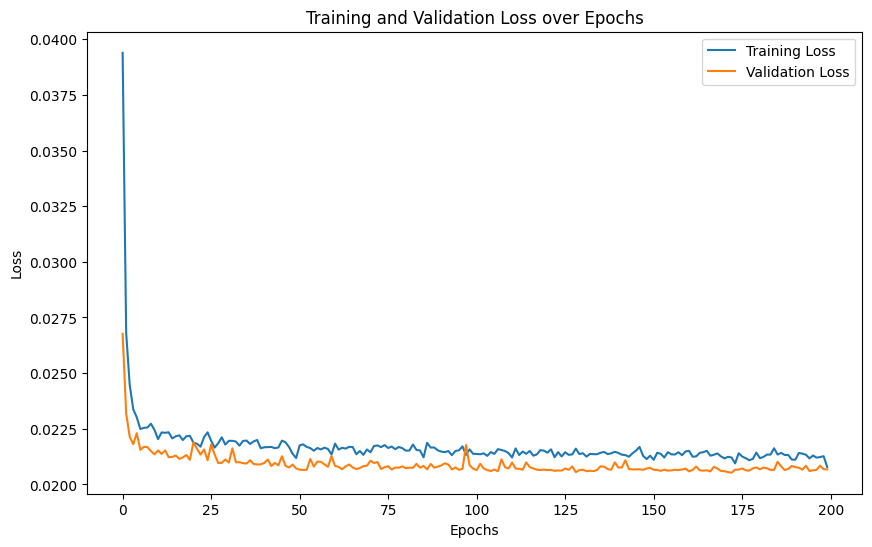

In [558]:
# Train the model and get loss data for both training and validation sets
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=200)

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))  
plt.plot(train_losses, label='Training Loss')  
plt.plot(val_losses, label='Validation Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.title('Training and Validation Loss over Epochs')  
plt.legend() 
plt.show()  



In [559]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_bert_model.pth'))
model.eval()

SimpleBERT(
  (embedding): Linear(in_features=6, out_features=64, bias=True)
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=25

In [560]:
# Predict on the test set
test_loss = 0.0
y_preds, y_trues = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        test_loss += loss.item() * inputs.size(0)

        y_preds.extend(outputs.squeeze().cpu().numpy())
        y_trues.extend(targets.squeeze().cpu().numpy())

test_loss /= len(test_loader.dataset)


Test Loss: 0.0211


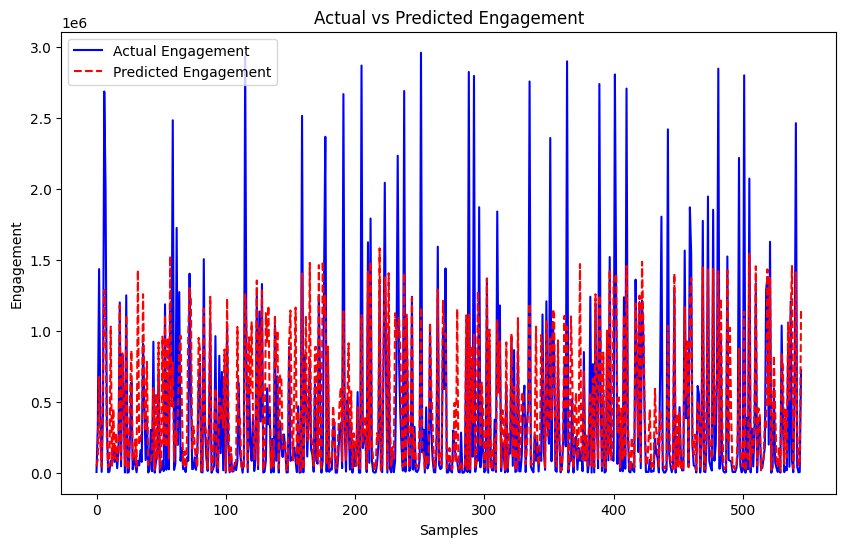

In [561]:
# Print test loss
print(f"Test Loss: {test_loss:.4f}")

# Rescale predictions to original scale
y_preds_rescaled = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1))
y_trues_rescaled = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1))

# Plot actual vs predicted engagement
plt.figure(figsize=(10, 6))
plt.plot(y_trues_rescaled, label='Actual Engagement', color='b')
plt.plot(y_preds_rescaled, label='Predicted Engagement', color='r', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Engagement')
plt.title('Actual vs Predicted Engagement')
plt.legend()
plt.show()

In [562]:
 #Load the best saved model
model.load_state_dict(torch.load('best_bert_model.pth'))
model.eval()

# Generate predictions (assuming 'test_loader' and 'model' are defined)
y_preds, y_trues = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_preds.extend(outputs.cpu().numpy())
        y_trues.extend(targets.cpu().numpy())

# Convert predictions and true values to numpy arrays
y_pred_rescaled = np.array(y_preds).reshape(-1, 1)
y_test_rescaled = np.array(y_trues).reshape(-1, 1)

# Evaluate peaks using local maxima with a comparator
true_local_max_indices = argrelextrema(y_test_rescaled.flatten(), comparator=np.greater, order=5)[0]  # Set 'order' to define neighborhood
pred_local_max_indices = argrelextrema(y_pred_rescaled.flatten(), comparator=np.greater, order=5)[0]
y_test_peak_labels = np.zeros_like(y_test_rescaled.flatten(), dtype=int)
y_pred_peak_labels = np.zeros_like(y_pred_rescaled.flatten(), dtype=int)
y_test_peak_labels[true_local_max_indices] = 1
y_pred_peak_labels[pred_local_max_indices] = 1

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_peak_labels, y_pred_peak_labels)
precision = precision_score(y_test_peak_labels, y_pred_peak_labels, zero_division=0)
recall = recall_score(y_test_peak_labels, y_pred_peak_labels, zero_division=0)
f1 = f1_score(y_test_peak_labels, y_pred_peak_labels, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8956
Precision: 0.3913
Recall: 0.3830
F1 Score: 0.3871


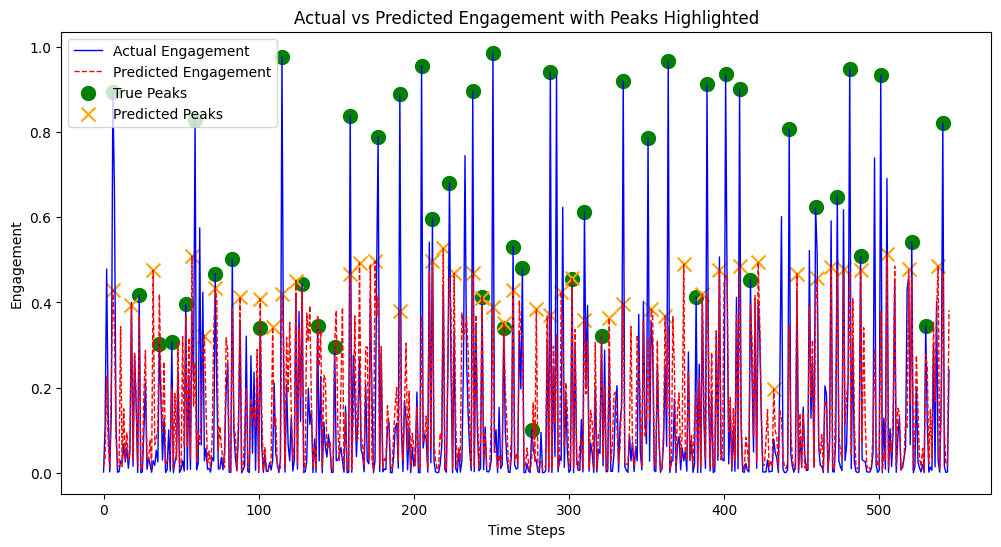

In [563]:
# Plot actual vs predicted engagement with peaks highlighted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Engagement', color='b', linewidth=1)
plt.plot(y_pred_rescaled, label='Predicted Engagement', color='r', linestyle='--', linewidth=1)
plt.scatter(true_local_max_indices, y_test_rescaled[true_local_max_indices], color='g', marker='o', s=100, label='True Peaks')
plt.scatter(pred_local_max_indices, y_pred_rescaled[pred_local_max_indices], color='orange', marker='x', s=100, label='Predicted Peaks')
plt.xlabel('Time Steps')
plt.ylabel('Engagement')
plt.title('Actual vs Predicted Engagement with Peaks Highlighted')
plt.legend()
plt.show()

Predicting 2023 Engagement: 100%|██████████| 365/365 [00:00<00:00, 826.05it/s]


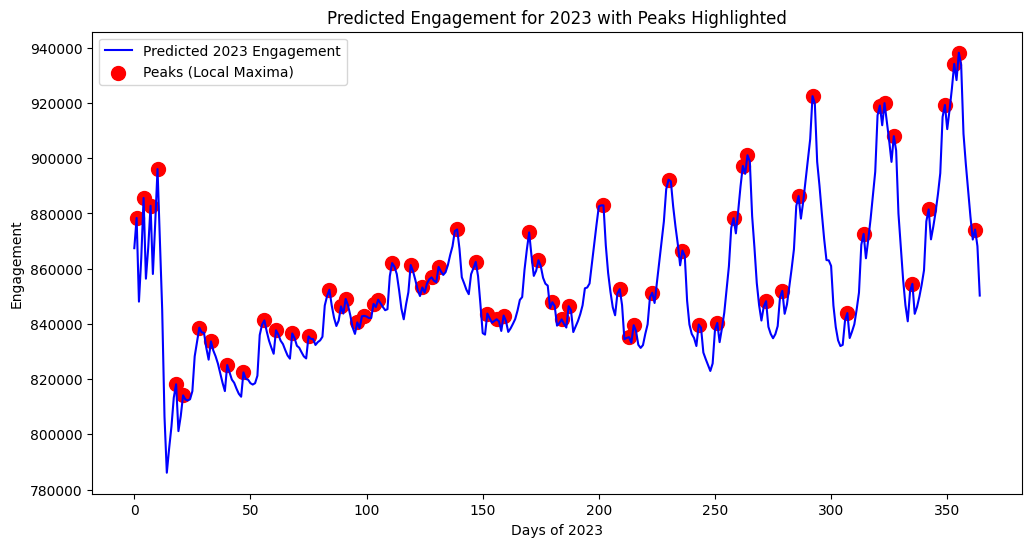

In [564]:
import torch
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema 

# Load and preprocess the data
data = pd.read_csv('data_processed_filtered_outlier_imputed.csv')
data['is_weekend'] = data['is_weekend'].apply(lambda x: 1 if x == 'True' else 0)

# Select features
selected_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend', 'engagement']
time_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend']
engagement_feature = ['engagement']

# Normalize time features and engagement separately
scaler_time = MinMaxScaler()
scaler_time.fit(data[time_features])

scaler_engagement = MinMaxScaler()
scaler_engagement.fit(data[engagement_feature])

# Prepare input data for prediction (using the last time_steps data from 2022)
data_2022 = data[data['tweet_year'] == 2022]
last_sequence = data_2022[selected_features].values[-time_steps:]

# Normalize the initial sequence
time_sequence_scaled = scaler_time.transform(pd.DataFrame(last_sequence[:, :-1], columns=time_features))
engagement_sequence_scaled = scaler_engagement.transform(pd.DataFrame(last_sequence[:, -1].reshape(-1, 1), columns=engagement_feature))

# Combine time features and engagement features
last_sequence_scaled = np.hstack((time_sequence_scaled, engagement_sequence_scaled))

# Convert last_sequence_scaled to torch tensor
current_sequence = torch.tensor(last_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: [1, time_steps, feature_size]

# Load the saved best model
model.load_state_dict(torch.load('best_bert_model.pth'))
model.eval()

# Initialize an empty list to store predicted engagement values for 2023
predicted_2023_scaled = []  

# Start date for 2023 prediction
last_date = pd.to_datetime(f"{int(data_2022.iloc[-1]['tweet_year'])}-{int(data_2022.iloc[-1]['tweet_month'])}-{int(data_2022.iloc[-1]['tweet_days'])}")

# Predict for 365 days in 2023
for i in tqdm(range(365), desc="Predicting 2023 Engagement", leave=True):
    # Calculate the current date
    current_date = last_date + timedelta(days=i + 1)

    # Compute time features for the current date
    tweet_year = current_date.year
    tweet_month = current_date.month
    tweet_days = current_date.day
    tweet_day = current_date.weekday()
    is_weekend = 1 if tweet_day in [5, 6] else 0

    # Create an array of new time features for the current day
    new_time_features = pd.DataFrame([[tweet_year, tweet_month, tweet_days, tweet_day, is_weekend]], columns=time_features)
    new_time_features_scaled = scaler_time.transform(new_time_features)  # Normalize the new time features

    # Extract engagement from the last time step of current_sequence
    engagement_features = current_sequence[0, -1:, -1].cpu().numpy().reshape(-1, 1)

    # Create new input by combining new time features and historical engagement
    new_input = np.hstack((new_time_features_scaled, engagement_features))

    # Update the input sequence (drop the first time step and add the new one)
    current_sequence = torch.cat([current_sequence[:, 1:, :], torch.tensor(new_input, dtype=torch.float32).unsqueeze(0).to(device)], dim=1)

    # Predict engagement for the next day using the model
    with torch.no_grad():
        predicted_value_scaled = model(current_sequence).cpu().numpy()  # Model expects [batch_size, seq_length, feature_size]
    
    # Save scaled prediction for later inverse transformation and visualization
    predicted_2023_scaled.append(predicted_value_scaled[0][0])  

# Convert predicted values to a NumPy array
predicted_2023_scaled = np.array(predicted_2023_scaled).reshape(-1, 1)

# Inverse normalization of the predicted engagement
predicted_2023 = scaler_engagement.inverse_transform(predicted_2023_scaled)  

# Find local maxima (peaks)
peak_indices = argrelextrema(predicted_2023.flatten(), comparator=np.greater)[0]  

# Plot predicted engagement for 2023 with peaks highlighted
plt.figure(figsize=(12, 6))
plt.plot(predicted_2023, label='Predicted 2023 Engagement', color='b')
plt.scatter(peak_indices, predicted_2023[peak_indices], color='r', marker='o', s=100, label='Peaks (Local Maxima)')
plt.xlabel('Days of 2023')
plt.ylabel('Engagement')
plt.title('Predicted Engagement for 2023 with Peaks Highlighted')
plt.legend()
plt.show()
